In [4]:
import sys
sys.path.append("..")

%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport pyfantom.network_tools

import plotly
#import plotly.offline as py
import plotly.plotly as py
plotly.tools.set_credentials_file(username="grst", api_key="afku7pa4yy")
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

from orangecontrib.bio.ontology import OBOOntology, OBOObject
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter
from copy import deepcopy, copy
import itertools
from pyfantom.network_tools import tag2name

sns.set_style("ticks")
sns.set_context("paper")
# py.init_notebook_mode()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
obo_corr = OBOOntology()
obo_corr.load(open("../data/ff-phase2-140729.corr.obo"))
col_vars = pd.read_csv("../data/column_vars.processed.csv", index_col=0)
delim_df = pd.read_csv("../data/delimiter_nodes.tsv", sep='\t', index_col=0)
lib_to_obo = {
    lib_id: obo_id for (lib_id, obo_id) in zip(col_vars.lib_id, col_vars.obo_id)
}

## Clustering
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [6]:
corr_mat_primary_df = pd.read_csv("../data/corr_mat.primary.tsv", sep=" ")
corr_mat_primary_df.rename(index=lib_to_obo, columns=lib_to_obo, inplace=True)
corr_mat_primary_df.head()
corr_mat_primary = corr_mat_primary_df.as_matrix()
link_mat = linkage(corr_mat_primary, "average").astype(np.dtype("double"))

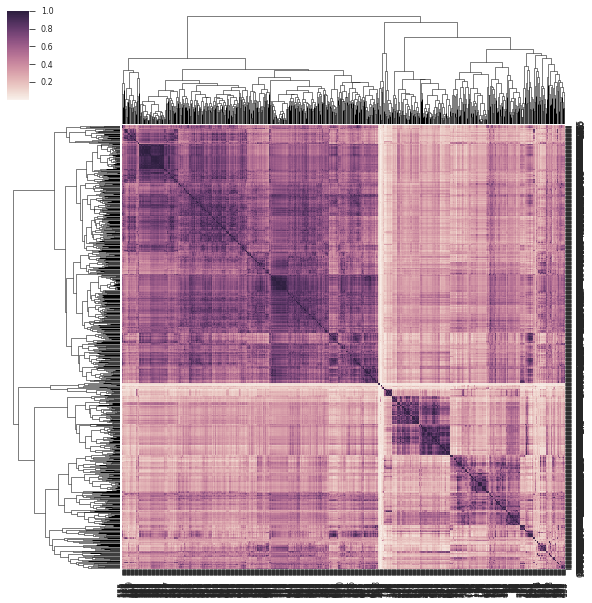

In [7]:
sns.clustermap(corr_mat_primary)

In [8]:
def common_super_terms(obo_ids): 
    cntr = Counter()
    for obo_id in obo_ids: 
        for term in obo_corr.super_terms(obo_id): 
            if not delim_df.loc[term.id, 'delimiter']: 
                cntr[tag2name(obo_corr, term.id)] += 1
    return cntr


def get_ratio(cntr, length): 
    for item, count in cntr.most_common(): 
        yield (item, count/length)

In [9]:
dendro = FF.create_dendrogram(corr_mat_primary, linkagefun=lambda x: linkage(x, "average"))

In [10]:
def rnd(x):
    return tuple((round(y, 4) for y in x))
def get_left_coordinate(data_item):
    return rnd((data_item["x"][0], data_item["y"][0]))
def get_right_coordinate(data_item):
    return rnd((data_item["x"][-1], data_item["y"][-1]))
def get_parent_coordinate(data_item):
    assert data_item["y"][1] == data_item["y"][2]
    return rnd((np.mean(data_item["x"][1:3]), data_item["y"][1]))

In [11]:
def get_leaf_nodes(ref_dict, coords, leaf_nodes=None):
    if leaf_nodes is None:
        leaf_nodes = []
    if coords[1] == 0: # y = 0 -> leaf
        layout = dendro['layout']['xaxis']
        i = layout['tickvals'].index(coords[0])
        leaf_id = layout['ticktext'][i]
        leaf_nodes.append(leaf_id)
    else:
        get_leaf_nodes(ref_dict, ref_dict[coords]["left"], leaf_nodes)
        get_leaf_nodes(ref_dict, ref_dict[coords]["right"], leaf_nodes)
    return leaf_nodes

In [12]:
def index2tag(leaf_indices):
    return [corr_mat_primary_df.index[int(i)] for i in leaf_indices]

In [13]:
def relabel_leafs(leaf_indices):
    return [tag2name(obo_corr, obo_id) for obo_id in index2tag(leaf_indices)]

In [14]:
ref_dict = {
    get_parent_coordinate(data_item): {
        "left": get_left_coordinate(data_item),
        "right": get_right_coordinate(data_item),
    } for data_item in dendro['data']
}

In [15]:
dendro_with_label = copy(dendro)
for coords, child_coords in ref_dict.items():
    leafs = get_leaf_nodes(ref_dict, coords)
    super_terms = common_super_terms(index2tag(leafs))
    dendro_with_label['data'].append(
        go.Scatter(
            x=coords[0],
            y=coords[1],
            mode="markers",
            #name="",
            text="<br>".join("{1}: {0}".format(*x) for x in itertools.islice(get_ratio(super_terms, len(leafs)), 5))
        )
    )

In [16]:
dendro_with_label['layout'].update({
        'width':900, 'height':700,
        'hovermode': 'closest',
    })
dendro_with_label['layout']['xaxis'].update({
        "tickangle": -90,
        'ticktext': relabel_leafs(dendro_with_label['layout']['xaxis']['ticktext'])
    })

In [17]:
corr_mat_primary.shape

(780, 780)

In [18]:
dendro_with_label

{'data': [{'marker': {'color': 'rgb(61,153,112)'},
   'mode': 'lines',
   'type': 'scatter',
   'x': array([ 15.,  15.,  25.,  25.]),
   'xaxis': 'x',
   'y': array([ 0.        ,  1.24267522,  1.24267522,  0.        ]),
   'yaxis': 'y'},
  {'marker': {'color': 'rgb(61,153,112)'},
   'mode': 'lines',
   'type': 'scatter',
   'x': array([  5.,   5.,  20.,  20.]),
   'xaxis': 'x',
   'y': array([ 0.        ,  2.30120094,  2.30120094,  1.24267522]),
   'yaxis': 'y'},
  {'marker': {'color': 'rgb(61,153,112)'},
   'mode': 'lines',
   'type': 'scatter',
   'x': array([ 35.,  35.,  45.,  45.]),
   'xaxis': 'x',
   'y': array([ 0.        ,  2.60478764,  2.60478764,  0.        ]),
   'yaxis': 'y'},
  {'marker': {'color': 'rgb(61,153,112)'},
   'mode': 'lines',
   'type': 'scatter',
   'x': array([ 12.5,  12.5,  40. ,  40. ]),
   'xaxis': 'x',
   'y': array([ 2.30120094,  3.11877541,  3.11877541,  2.60478764]),
   'yaxis': 'y'},
  {'marker': {'color': 'rgb(61,153,112)'},
   'mode': 'lines',
   't

In [19]:
py.iplot(dendro_with_label, filename='enhanced_dendrogram')